In [5]:
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# === BaseTransform ===
class BaseTransform:
    def __init__(self, p: float = 1.0):
        if not (0.0 <= p <= 1.0):
            raise ValueError("p must be in [0, 1]")
        self.p = p

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.apply(img)
        return img


# === RandomCrop ===
class RandomCrop(BaseTransform):
    def __init__(self, p: float = 1.0, size=None):
        super().__init__(p)
        self.size = size

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if self.size is None:
            new_h, new_w = max(1, h // 2), max(1, w // 2)
        else:
            if isinstance(self.size, int):
                new_h = new_w = self.size
            else:
                new_h, new_w = self.size

        # Если запрошенный размер больше изображения — возвращаем оригинал
        if new_h > h or new_w > w:
            return img

        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        return img.crop((left, top, left + new_w, top + new_h))


# === RandomRotate ===
class RandomRotate(BaseTransform):
    def __init__(self, p: float = 1.0, degrees=30):
        super().__init__(p)
        if isinstance(degrees, (tuple, list)):
            if len(degrees) != 2:
                raise ValueError("degrees must be int or (min, max)")
            self.min_deg, self.max_deg = degrees
        else:
            self.min_deg, self.max_deg = -abs(degrees), abs(degrees)

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(self.min_deg, self.max_deg)
        return img.rotate(angle, resample=Image.BICUBIC, expand=False)


# === RandomZoom ===
class RandomZoom(BaseTransform):
    def __init__(self, p: float = 1.0, zoom_range=(0.8, 1.2)):
        super().__init__(p)
        if isinstance(zoom_range, (tuple, list)) and len(zoom_range) == 2:
            self.min_zoom, self.max_zoom = sorted(zoom_range)
        else:
            raise ValueError("zoom_range must be (min, max)")

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        zoom = random.uniform(self.min_zoom, self.max_zoom)
        new_w, new_h = int(w * zoom), int(h * zoom)

        if new_w == 0 or new_h == 0:
            return img

        resized = img.resize((new_w, new_h), Image.BICUBIC)

        if zoom >= 1.0:
            # Обрезаем до исходного размера
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            return resized.crop((left, top, left + w, top + h))
        else:
            # Дополняем чёрным до исходного размера
            new_img = Image.new("RGB", (w, h))
            paste_x = (w - new_w) // 2
            paste_y = (h - new_h) // 2
            new_img.paste(resized, (paste_x, paste_y))
            return new_img


# === ToTensor ===
class ToTensor:
    def __call__(self, img: Image.Image) -> np.ndarray:
        """Возвращает массив в формате (C, H, W) с float32 значениями в [0,1]"""
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_np = np.array(img).astype(np.float32) / 255.0
        return np.transpose(img_np, (2, 0, 1))  # (H, W, C) -> (C, H, W)


# === Compose ===
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img: Image.Image):
        for t in self.transforms:
            img = t(img)
        return img

In [6]:
def create_test_image(size=(128, 128)):
    img = Image.new('RGB', size, color='white')
    draw = ImageDraw.Draw(img)
    # Красный квадрат
    draw.rectangle([30, 30, 90, 90], outline='red', width=3)
    # Синий круг
    draw.ellipse([40, 40, 80, 80], outline='blue', width=2)
    # Зелёная линия
    draw.line([20, 110, 100, 110], fill='green', width=4)
    return img

original_img = create_test_image()

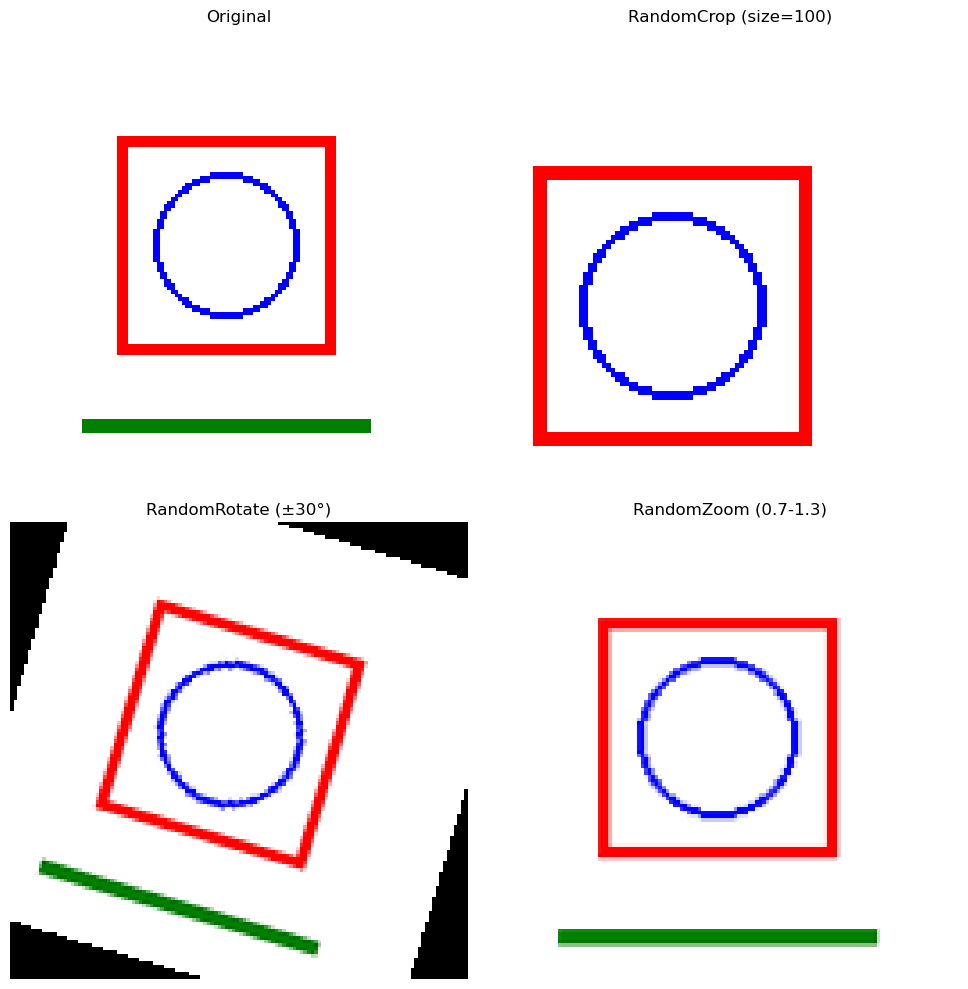

In [7]:
# Фиксируем seed для воспроизводимости
random.seed(42)

# Создаём трансформации с p=1.0 (гарантированное применение)
transforms_to_show = [
    ("Original", lambda x: x),
    ("RandomCrop (size=100)", RandomCrop(p=1.0, size=100)),
    ("RandomRotate (±30°)", RandomRotate(p=1.0, degrees=30)),
    ("RandomZoom (0.7-1.3)", RandomZoom(p=1.0, zoom_range=(0.7, 1.3))),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (title, transform) in enumerate(transforms_to_show):
    img_copy = original_img.copy()
    result = transform(img_copy)
    axes[idx].imshow(result)
    axes[idx].set_title(title, fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [8]:
print("=== ТЕСТИРОВАНИЕ ===")

# Тест 1: Воспроизводимость
random.seed(100)
np.random.seed(100)
t1 = Compose([
    RandomCrop(p=1.0, size=100),
    RandomRotate(p=1.0, degrees=20),
    RandomZoom(p=1.0, zoom_range=(0.9, 1.1))
])
result_a = t1(original_img.copy())

random.seed(100)
np.random.seed(100)
result_b = t1(original_img.copy())

print("Воспроизводимость:", result_a.tobytes() == result_b.tobytes())

# Тест 2: p=0 → всегда оригинал
t2 = RandomRotate(p=0.0, degrees=45)
result = t2(original_img.copy())
print("p=0 → оригинал:", original_img.tobytes() == result.tobytes())

# Тест 3: Crop больше изображения
t3 = RandomCrop(p=1.0, size=200)
result = t3(original_img.copy())
print("Crop > size → оригинал:", original_img.tobytes() == result.tobytes())

# Тест 4: ToTensor корректность
to_tensor = ToTensor()
tensor = to_tensor(original_img)
print("ToTensor shape:", tensor.shape, "(ожидаемо (3, 128, 128))")
print("ToTensor dtype:", tensor.dtype, "(ожидаемо float32)")
print("ToTensor range:", tensor.min(), "-", tensor.max(), "(ожидаемо 0.0 - 1.0)")

# Тест 5: Compose с p<1
random.seed(50)
t4 = Compose([
    RandomRotate(p=0.0, degrees=30),  # никогда не применяется
    RandomZoom(p=1.0, zoom_range=(1.0, 1.0))  # zoom=1.0 → оригинал
])
result = t4(original_img.copy())
print("Compose с p<1 и нейтральным zoom:", original_img.tobytes() == result.tobytes())

=== ТЕСТИРОВАНИЕ ===
Воспроизводимость: True
p=0 → оригинал: True
Crop > size → оригинал: True
ToTensor shape: (3, 128, 128) (ожидаемо (3, 128, 128))
ToTensor dtype: float32 (ожидаемо float32)
ToTensor range: 0.0 - 1.0 (ожидаемо 0.0 - 1.0)
Compose с p<1 и нейтральным zoom: True
